## Imports

In [1]:
import os
import sys
import pathlib

import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt 
import albumentations as albu

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# Fix to be able to import python modules inside a notebook
os.chdir('..')

# Useful extensions
# %load_ext watermark
# %watermark -v -n -m -p numpy,torch,albumentations,photosynthesis_metrics

%load_ext autoreload
%autoreload 2

# Nice plot formating
%matplotlib inline

In [3]:
!ls

configs  notebooks	README.md	  train_catalyst.py
data	 predict.py	requirements.txt  train.py
logs	 preprocess.py	src


## Explore data
### Train
- **68811** files in total
- **3097** folders with images

3088 classes, because some folders didn't contain any images (empty classes). Some other folders contained only 1 image. I manualy deleted them.

### Test A
- Number of queries: **9600**
- Library size: **49804**

### Test B
- Number of queries: **17092**
- Library size: **97547**

### Compute distribution of sizes

In [6]:
df = pd.read_csv("data/interim/train_val.csv")
df.head()

,file_path,label,original_size,aspect_ratio,is_query
0,DIGIX_000000/19BRS2LZXV4M865W.jpg,0,"(1080, 1440)",0.75,True
1,DIGIX_000000/4M83NC5JGYK0SP2Q.jpg,0,"(800, 800)",1.00,False
2,DIGIX_000000/5W97AIZ2CE43XHQD.jpg,0,"(800, 800)",1.00,False
3,DIGIX_000000/7WMZS8Q2V06E54FL.jpg,0,"(1368, 1824)",0.75,True
4,DIGIX_000000/9AYO2KC0ZLM3VU78.jpg,0,"(800, 800)",1.00,False


In [5]:
df_test = pd.read_csv("data/interim/test_A.csv")
df_test.head()

,file_path,original_size,aspect_ratio,is_query
0,gallery/0128JNE6U7OYQLRP.jpg,"(988, 654)",1.5107,0.0
1,gallery/01458WCN7FJAMLXP.jpg,"(729, 1296)",0.5625,0.0
2,gallery/015EGI4R893U6CTA.jpg,"(790, 683)",1.1567,0.0
3,gallery/015IB4PO73TSAGY8.jpg,"(1080, 1440)",0.7500,0.0
4,gallery/015VJEZKNTSDPM9F.jpg,"(1000, 1000)",1.0000,0.0


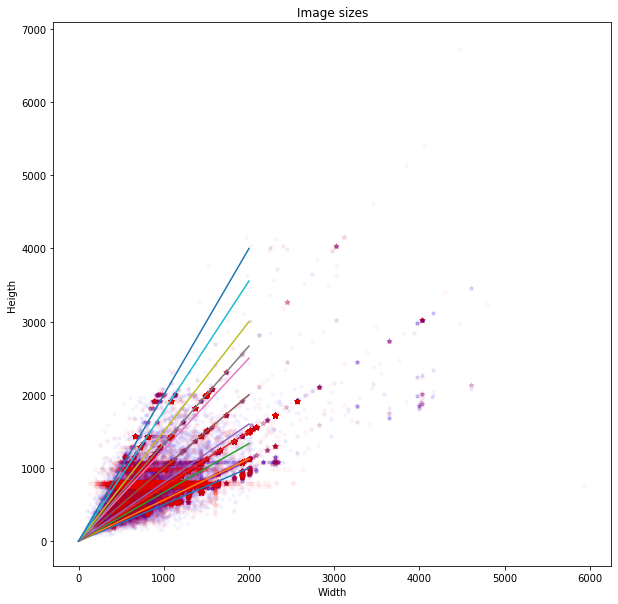

In [20]:
plt.figure(figsize=(10,10))
plt.title("Image sizes")
plt.xlabel("Width")
plt.ylabel("Heigth")


H = [eval(x)[0] for x in df["original_size"]]
W = [eval(x)[1] for x in df["original_size"]]
plt.scatter(W, H, marker='.', c='b', alpha=0.03)

H = [eval(x)[0] for x in df_test["original_size"]]
W = [eval(x)[1] for x in df_test["original_size"]]
plt.scatter(W, H, marker='*', c='r', alpha=0.03)

ap = [2, 16/9, 3/2, 4/3, 5/4, 1, 4/5, 3/4, 2/3, 9/16, 1/2]
x = np.arange(2000)

for aspect in ap:
    y = x / aspect
    
    plt.plot(x, y)

In [30]:
# Convert label.txt to DF
# Add info about original size
# Add info about aspect ratio
# Add info about query / not query

root = "data/interim"

# # Read file with labels
with open("data/raw/train_data/label.txt") as f:
    data = f.readlines()

filenames, targets = [], []
for row in data:
    path, label = row.strip("\n").split(",")
    filenames.append(path)
    targets.append(int(label))
    
targets[:10], filenames[:10]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 ['DIGIX_000000/MSWZD6T13QJCNV9X.jpg',
  'DIGIX_000000/I18OVRJHK2U59BCY.jpg',
  'DIGIX_000000/MK7GUA9JLS8RO21X.jpg',
  'DIGIX_000000/UF26GP1XA8S4Y7ZJ.jpg',
  'DIGIX_000000/SUFP9IC751BADZLE.jpg',
  'DIGIX_000000/T1XJ8ZBWFC9PYR3U.jpg',
  'DIGIX_000000/PMQWS5BNO80FHIC3.jpg',
  'DIGIX_000000/4M83NC5JGYK0SP2Q.jpg',
  'DIGIX_000000/PIJ53Y4UB7ZW1DCQ.jpg',
  'DIGIX_000000/TGYOWRFUAN0J8X49.jpg'])

In [27]:
# def generate_size_info_df(paths, df) -> pd.DataFrame:
#     for path in tqdm(paths):
#         id_ = str(path).split('/')[-1].replace('.jpg', '')
#         img = cv2.imread(str(path))
#         h, w, c = img.shape
#         df.loc[id_, 'height'] = h
#         df.loc[id_, 'width'] = w
#     return df.reset_index().sort_values(by='id')


# # Read file with labels
# with open("data/raw/train_data/label.txt") as f:
#     data = f.readlines()

# self.filenames, self.targets = [], []
# for row in data:
#     path, label = row.strip("\n").split(",")
#     self.filenames.append(os.path.join(root, f"train_data_{size}", path))
#     self.targets.append(int(label))
# self.targets = torch.tensor(self.targets, dtype=torch.float)



import os.path
def sort_ar(valdir):
    idx2ar_file = valdir+'/../sorted_idxar.p'
    if os.path.isfile(idx2ar_file): return pickle.load(open(idx2ar_file, 'rb'))
    print('Creating AR indexes. Please be patient this may take a couple minutes...')
    val_dataset = datasets.ImageFolder(valdir) # AS: TODO: use Image.open instead of looping through dataset
    sizes = [img[0].size for img in tqdm(val_dataset, total=len(val_dataset))]
    idx_ar = [(i, round(s[0]/s[1], 5)) for i,s in enumerate(sizes)]
    sorted_idxar = sorted(idx_ar, key=lambda x: x[1])
    pickle.dump(sorted_idxar, open(idx2ar_file, 'wb'))
    print('Done')
    return sorted_idxar

def chunks(l, n):
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

def map_idx2ar(idx_ar_sorted, batch_size):
    ar_chunks = list(chunks(idx_ar_sorted, batch_size))
    idx2ar = {}
    for chunk in ar_chunks:
        idxs, ars = list(zip(*chunk))
        mean = round(np.mean(ars), 5)
        for idx in idxs: idx2ar[idx] = mean
    return idx2ar

NameError: name 'self' is not defined

### View images

In [4]:
from src.datasets import ClassificationDataset, get_dataloaders
from src.augmentations import get_aug

3088


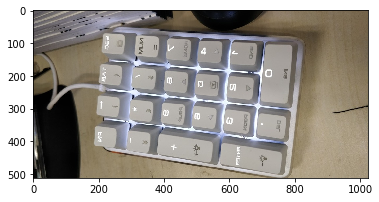

In [20]:
dataset = ClassificationDataset(root="data/interim", transform=None, train=True, size=512)
# plt.imshow(dataset[0][0])
# plt.subplot(1, 3, 3)
plt.imshow(dataset[20000][0].permute(2, 1, 0))

print(len(set(dataset.targets)))

In [ ]:
for i i

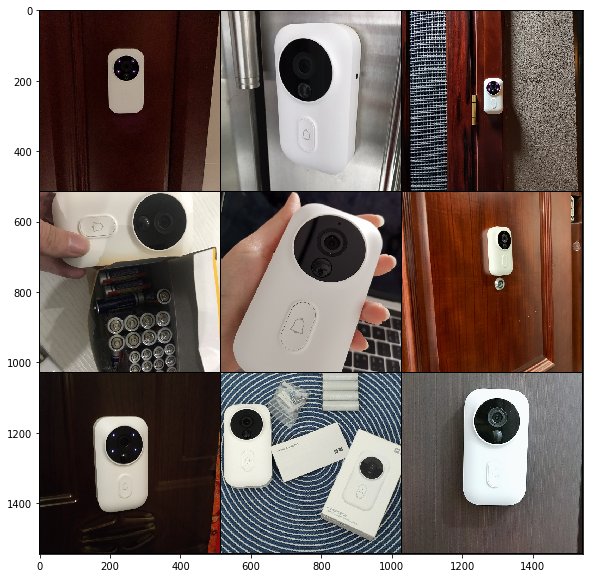

In [19]:
# Init dataset and plot 4 images with the same label to check, if label is correct
SIZE = 512
AUG = "val"

# Get augmentations
aug = get_aug(AUG, size=SIZE)

dataset = ClassificationDataset(root="data/interim", transform=aug, train=True, size=SIZE, val_pct=0.2)
# dataset = ClassificationDataset(root="data/interim", transform=None, train=True, size=SIZE, val_pct=0.2)

def plot_same_class(dataset, idx, N=4):
    image, target = dataset[idx]
    same_idx = torch.arange(len(dataset))[(torch.tensor(dataset.targets) == target)]
    # Filter initial index
    same_idx = same_idx[same_idx != idx]
    assert len(same_idx) > N, "Not enough images to take"
    images = [image]
    
    for i in range(N - 1):
        image, _ = dataset[same_idx[i]]
        images.append(image)
    
    images = torch.stack(images)

    grid = torchvision.utils.make_grid(images, nrow=3, normalize=True, scale_each=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute((1,2,0)))


plot_same_class(dataset, idx=300, N=9)

In [ ]:
from src.augmentations import get_aug
import torchvision

train_loader, val_loader = get_dataloaders(
    root="data/interim",
    augmentation="hard",
    batch_size=9,
    size=384,
    val_size=384,
    workers=6,
)

In [ ]:
for batch in train_loader:
    train_images, labels = batch
    break

for batch in val_loader:
    val_images, labels = batch
    break
    

train_grid = torchvision.utils.make_grid(train_images, nrow=3, normalize=True, scale_each=True)
val_grid = torchvision.utils.make_grid(val_images, nrow=3, normalize=True, scale_each=True)
grid = torch.cat([train_grid, val_grid], dim=2)
plt.figure(figsize=(30, 10))
plt.imshow(grid.permute((1,2,0)).cpu())

albu.Cutout()

In [ ]:
len(torch.FloatTensor(10).uniform_() > 0.8)


## Implement metrics

### CMC score